# Project Name: Cell Counter
> Version : 0.1\
> Course : Python Chilla

**Feel free to collaborate**

C:\Users\Ali\anaconda3\envs\python-chilla\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


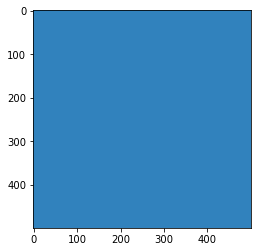

In [89]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage.measure import regionprops
from skimage.morphology import watershed
from scipy.ndimage.morphology import binary_erosion, binary_dilation, distance_transform_edt
from scipy.ndimage import label

import pandas as pd


img = io.imread('bac.jpg')

a = cv2.GaussianBlur(img,(5,5),cv2.BORDER_DEFAULT)
a = np.sum(a, axis=2)
a_thr = a < 1
plt.imshow(a)

# clean up specks
a_thr = binary_erosion(a_thr, iterations = 1)
a_thr = binary_dilation(a_thr, iterations = 1)

# do distance transform as prepartion for watershed
distances = distance_transform_edt(a_thr)

# find watershed seeds
seeds = peak_local_max(distances, indices =False, min_distance=20, footprint=np.ones((3,3)))
seeds = label(seeds)[0]

# watershed
ws = watershed(a, seeds, mask=a_thr)

plt.imshow(ws, cmap='tab20c')

C:\Users\Ali\anaconda3\envs\python-chilla\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


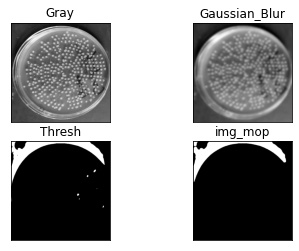

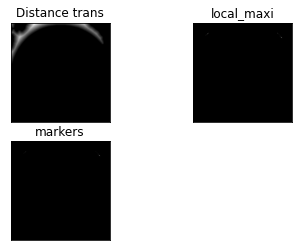

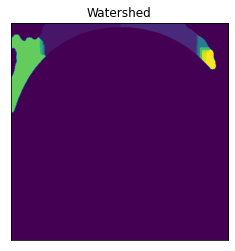

Particle 7 | Area (nm^2): 3343; Equivalent diameter (nm): 65
Particle 12 | Area (nm^2): 1487; Equivalent diameter (nm): 43
Particle 16 | Area (nm^2): 1387; Equivalent diameter (nm): 42
Particle 17 | Area (nm^2): 4593; Equivalent diameter (nm): 76


In [85]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from skimage.measure import regionprops

#----------------------------------------------------------------------------------------------------------------------#
# IMAGE PRETREATMENT

img = cv2.imread('bac.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
Gaussian_Blur = cv2.GaussianBlur(gray,(21, 21), cv2.BORDER_DEFAULT)

# Use fixed threshold to mask black areas
_, thresh = cv2.threshold(Gaussian_Blur, 90, 255, cv2.THRESH_BINARY_INV) # _ = 30

# Morphological closing to close holes inside particles; opening to get rid of noise
img_mop1 = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7)))
img_mop = cv2.morphologyEx(img_mop1, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15)))
tiled_h = np.hstack((img_mop1, img_mop)) # stack images side-by-side

plt.figure('Pretreatment')
plt.subplot(2, 2, 1) # Figure two has subplots 2 raw, 2 columns, and this is plot 1
plt.gca().set_title('Gray')
plt.xticks([]), plt.yticks([]) # To hide axes
plt.imshow(gray, cmap='gray')

plt.subplot(2, 2, 2)
plt.gca().set_title('Gaussian_Blur')
plt.xticks([]), plt.yticks([])
plt.imshow(Gaussian_Blur, cmap='gray')

plt.subplot(2, 2, 3)
plt.gca().set_title('Thresh')
plt.xticks([]), plt.yticks([])
plt.imshow(thresh, cmap='gray')

plt.subplot(2, 2, 4)
plt.gca().set_title('img_mop')
plt.xticks([]), plt.yticks([])
plt.imshow(img_mop, cmap='gray')


#----------------------------------------------------------------------------------------------------------------------#
# WTERSHED WITH SKIMAGE

distance = ndi.distance_transform_edt(img_mop) # Calculates distance of pixels from background

#Find peaks in an image as coordinate list or boolean mask.
local_maxi = peak_local_max(distance, indices=False, min_distance=50, footprint=np.ones((3, 3)), labels=img_mop)
markers = ndi.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=img_mop)

plt.figure('Processing')
plt.subplot(2, 2, 1) # Figure two has subplots 2 raw, 2 columns, and this is plot 1
plt.gca().set_title('Distance trans')
plt.xticks([]), plt.yticks([]) # To hide axes
plt.imshow(distance, cmap='gray')

plt.subplot(2, 2, 2)
plt.gca().set_title('local_maxi')
plt.xticks([]), plt.yticks([])
plt.imshow(local_maxi, cmap='gray')

plt.subplot(2, 2, 3)
plt.gca().set_title('markers')
plt.xticks([]), plt.yticks([])
plt.imshow(markers, cmap='gray')

plt.figure('Watershed')
plt.gca().set_title('Watershed')
plt.xticks([]), plt.yticks([]) # To hide axes
plt.imshow(labels)

plt.show()

#----------------------------------------------------------------------------------------------------------------------#
# DATA ANALYSIS

# Regionprops: Measure properties of labeled image regions. It can give A LOT of properties, see info in:
# https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops
props = regionprops(labels)

# Determine scale bar (largest object) and set the scale.
thr_size = 6000
for p in props:
    if p['area'] > thr_size:
        box = p['bbox']
        scale = box[3]-box[1]


# Remove smaller detected areas, and give area and diameter for each of the remaining particles.
for p in props:
    if p['equivalent_diameter'] > 15 and p['equivalent_diameter'] < 40:
        entry = [p['label'], p['area'], p['equivalent_diameter'], *p['centroid']]
        n = entry[0]
        y = entry[3]
        x = entry[4]-60 # so that number shows on the left of particle
        cv2.putText(img, str(n), (int(x), int(y)), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 255, 0), 2)
        print('Particle {} | Area (nm^2): {}; Equivalent diameter (nm): {}'.format(str(n),
                                            str(int(((entry[1]*40000)/(scale**2)))), str(int((entry[2])*200/scale))))

cv2.imshow('img', img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [15]:
# Finding sure foreground area using distance transform and thresholding
#intensities of the points inside the foreground regions are changed to 
#distance their respective distances from the closest 0 value (boundary).
#https://www.tutorialspoint.com/opencv/opencv_distance_transformation.htm
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)


#Let us threshold the dist transform by starting at 1/2 its max value.
#print(dist_transform.max()) gives about 21.9
ret2, sure_fg = cv2.threshold(dist_transform,0.001*dist_transform.max(),255,0)

#Later you realize that 0.25* max value will not separate the cells well.
#High value like 0.7 will not recognize some cells. 0.5 seems to be a good compromize

# Unknown ambiguous region is nothing but bkground - foreground
sure_fg = np.uint8(sure_fg)
cv2.imshow("Count", sure_fg)
cv2.imshow("Orignal", img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:


unknown = cv2.subtract(sure_bg,sure_fg)

#Now we create a marker and label the regions inside. 
# For sure regions, both foreground and background will be labeled with positive numbers.
# Unknown regions will be labeled 0. 
#For markers let us use ConnectedComponents. 
ret3, markers = cv2.connectedComponents(sure_fg)

#One problem rightnow is that the entire background pixels is given value 0.
#This means watershed considers this region as unknown.
#So let us add 10 to all labels so that sure background is not 0, but 10
markers = markers+10

# Now, mark the region of unknown with zero
markers[unknown==255] = 0
#plt.imshow(markers, cmap='jet')   #Look at the 3 distinct regions.

#Now we are ready for watershed filling. 
markers = cv2.watershed(img,markers)
#The boundary region will be marked -1
#https://docs.opencv.org/3.3.1/d7/d1b/group__imgproc__misc.html#ga3267243e4d3f95165d55a618c65ac6e1

#Let us color boundaries in yellow. 
img[markers == -1] = [0,255,255]  

img2 = color.label2rgb(markers, bg_label=0)

#cv2.imshow('Overlay on original image', img)
#cv2.imshow('Colored Grains', img2)
#cv2.waitKey(0)

#Now, time to extract properties of detected cells
# regionprops function in skimage measure module calculates useful parameters for each object.
regions = measure.regionprops(markers, intensity_image=cells)

#Can print various parameters for all objects
for prop in regions:
    print('Label: {} Area: {}'.format(prop.label, prop.area))

#Best way is to output all properties to a csv file
#Let us pick which ones we want to export. 

propList = ['Area',
            'equivalent_diameter', #Added... verify if it works
            'orientation', #Added, verify if it works. Angle btwn x-axis and major axis.
            'MajorAxisLength',
            'MinorAxisLength',
            'Perimeter',
            'MinIntensity',
            'MeanIntensity',
            'MaxIntensity']    
    

output_file = open('cell_measurements.csv', 'w')
output_file.write(',' + ",".join(propList) + '\n') #join strings in array by commas, leave first cell blank
#First cell blank to leave room for header (column names)

for region_props in regions:
    #output cluster properties to the excel file
    output_file.write(str(region_props['Label']))
    for i,prop in enumerate(propList):
        if(prop == 'Area'): 
            to_print = region_props[prop]*pixels_to_um**2   #Convert pixel square to um square
        elif(prop == 'orientation'): 
            to_print = region_props[prop]*57.2958  #Convert to degrees from radians
        elif(prop.find('Intensity') < 0):          # Any prop without Intensity in its name
            to_print = region_props[prop]*pixels_to_um
        else: 
            to_print = region_props[prop]     #Reamining props, basically the ones with Intensity in its name
        output_file.write(',' + str(to_print))
    output_file.write('\n')

# Method 1

In [26]:
import cv2
def is_contour_bad(c):
	# approximate the contour
	peri = cv2.arcLength(c, True)
	approx = cv2.approxPolyDP(c, 0.02 * peri, True)
	# the contour is 'bad' if it is not a rectangle
	return not len(approx) == 4
# load the shapes image, convert it to grayscale, and edge edges in
# the image
def get_img(img_path):
	image = cv2.imread(img_path)
	gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	edged = cv2.Canny(gray, 60, 150)
	cv2.imshow("Original", image)
	# find contours in the image and initialize the mask that will be
	# used to remove the bad contours
	cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	mask = np.ones(image.shape[:2], dtype="uint8") * 255
	# loop over the contours
	for c in cnts:
		# if the contour is bad, draw it on the mask
		if is_contour_bad(c):
			cv2.drawContours(mask, [c], -1, 0, -1)
	# remove the contours from the image and show the resulting images
	image = cv2.bitwise_and(image, image, mask=mask)
	print("Cell in This Image is : ", len(cnts))
	cv2.imwrite("cell_count.jpg", image)

	cv2.imshow("Mask", mask)
	cv2.imwrite("cell_mask.jpg", mask)

	cv2.imshow("After", image)
	cv2.waitKey(0)
	cv2.destroyAllWindows()

In [84]:
image = cv2.imread('bac.jpg')
img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
(thresh, im_bw) = cv2.threshold(img_gray, 0, 0, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
# ret, thresh = cv2.threshold(img_gray, 170, 255, cv2.THRESH_BINARY)
thresh = 180
im_bw = cv2.threshold(img_gray, thresh, 255, cv2.THRESH_BINARY)[1]

edge_detected_image = cv2.Canny(im_bw, 75, 200)
 

contours, hierarchy = cv2.findContours(edge_detected_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

contour_list = []
for contour in contours:
    approx = cv2.approxPolyDP(contour,0.01*cv2.arcLength(contour,True),True)
    area = cv2.contourArea(contour)
    if ((len(approx) > 8) & (len(approx) < 50) & (area > 30) ):
        contour_list.append(contour)
edge_detected = cv2.drawContours(image, contours,  -1, (0,0,120), 1)

cv2.imshow("Orignal", image)
cv2.imshow("wb", edge_detected)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [64]:
import cv2
from skimage.segmentation import clear_border
raw_image = cv2.imread('bac.jpg')
image = raw_image.copy()
raw_image = cv2.normalize(raw_image, raw_image, 0, 255, cv2.NORM_MINMAX)
print(raw_image.shape)

# bilateral_filtered_image = cv2.bilateralFilter(raw_image, 5, 175, 175)
img_gray = cv2.cvtColor(raw_image, cv2.COLOR_BGR2GRAY)
# apply binary thresholding
ret, thresh = cv2.threshold(img_gray, 170, 255, cv2.THRESH_BINARY)
kernel = np.ones((3,3),np.uint8)
opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations = 1)
opening = clear_border(opening) #Remove edge touching grains
edge_detected_image = cv2.Canny(thresh, 75, 200)
 

contours, hierarchy = cv2.findContours(opening, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

contour_list = []
for contour in contours:
    approx = cv2.approxPolyDP(contour,0.01*cv2.arcLength(contour,True),True)
    area = cv2.contourArea(contour)
    if ((len(approx) > 8) & (len(approx) < 50) & (area > 30) ):
        contour_list.append(contour)

edge_detected_image = cv2.drawContours(image, contour_list,  -1, (0,0,120), 1)
print("Total Blobs is: ", len(contour_list))
# cv2.imshow('Original Image', raw_image)
# cv2.imshow('Bilateral', bilateral_filtered_image)
# cv2.imshow('Edge', edge_detected_image)
# cv2.imshow('Objects Detected',raw_image)
# cv2.imwrite('Img.jpg', edge_detected_image )
# cv2.imwrite("New.jpg", edge_detected_image)
cv2.imshow("Count", raw_image)
cv2.imshow("Orignal", edge_detected_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

(500, 500, 3)
Total Blobs is:  211


In [54]:
import cv2

# read the image
image = cv2.imread('bac.jpg')
# convert the image to grayscale format
image = cv2.normalize(image, image, 0, 255, cv2.NORM_MINMAX)
img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# apply binary thresholding
ret, thresh = cv2.threshold(img_gray, 170, 255, cv2.THRESH_BINARY)
edge_detected_image = cv2.Canny(thresh, 75, 200)

# visualize the binary image
# detect the contours on the binary image using cv2.CHAIN_APPROX_NONE
contours, hierarchy = cv2.findContours(image=edge_detected_image, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)

contour_list = []
for contour in contours:
    approx = cv2.approxPolyDP(contour,0.01*cv2.arcLength(contour,True),True)
    area = cv2.contourArea(contour)
    if ((len(approx) > 8) & (len(approx) < 50) & (area > 35) ):
        contour_list.append(contour)     
# draw contours on the original image
image_copy = image.copy()
final = cv2.drawContours(image=image_copy, contours=contour_list, contourIdx=-1, color=(0, 255, 0), thickness=1, lineType=cv2.LINE_AA)

# edge_detected_image = cv2.drawContours(raw_image, contour_list,  -1, (0,0,120), 2)
# see the results
print("Total Blobs is: ", len(contour_list))

# cv2.imshow('canny ', edge_detected_image)
cv2.imshow("Count", final)
cv2.imshow("Orignal", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

Total Blobs is:  432


# Method 2

In [34]:
import cv2
import numpy as np

# Load image, grayscale, Otsu's threshold
image = cv2.imread('bac.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
#cv2.imwrite('thresh.jpg', thresh)

# Filter out large non-connecting objects
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    area = cv2.contourArea(c)
    #print(area)
    if area < 200 and area > 0:
        cv2.drawContours(thresh,[c],0,0,-1)

# Morph open using elliptical shaped kernel
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=3)

# Find circles 
cnts = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    area = cv2.contourArea(c)
    if area > 20 and area < 50:
        ((x, y), r) = cv2.minEnclosingCircle(c)
        cv2.circle(image, (int(x), int(y)), int(r), (36, 255, 12), 2)

cv2.namedWindow('orig', cv2.WINDOW_NORMAL)
cv2.imshow('orig', thresh)
cv2.namedWindow('image', cv2.WINDOW_NORMAL)
cv2.imshow('image', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
# matplotlib.rcParams["figure.figsize"] = (5.0, 5.0)
# matplotlib.rcParams["image.cmap"] = 'gray'
%matplotlib inline

img = cv2.imread("bac.jpg", cv2.IMREAD_GRAYSCALE)
th, img_thresh = cv2.threshold(img, 180, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# plt.imshow(img_thresh)
kernel_size = 3
element = np.ones((kernel_size,kernel_size), np.uint8)
img_closed = cv2.morphologyEx(img_thresh, cv2.MORPH_CLOSE, element)
img_opened = cv2.morphologyEx(img_closed, cv2.MORPH_OPEN, element)
_, img_labels = cv2.connectedComponents(img_opened)
# plt.imshow(img_labels)
# plt.imshow(img_closed)
im = cv2.resize(img_closed, (500, 500))
cv2.imshow('Mask', im)
print('The Maximum Number of Bactaria is: ',np.max(img_labels))
# cv2.imshow('original', original)
cv2.waitKey(0)
cv2.destroyAllWindows()


The Maximum Number of Bactaria is:  219


# Resizing of Image

In [5]:
import cv2
 
img = cv2.imread('bactaria.jpg', cv2.IMREAD_UNCHANGED)
 
print('Original Dimensions : ',img.shape)
 
scale_percent = 60 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (500, 500)
  
# resize image
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
cv2.imwrite("bac.jpg", resized)
 
print('Resized Dimensions : ',resized.shape)
 
cv2.imshow("Resized image", resized)
cv2.waitKey(0)
cv2.destroyAllWindows()

Original Dimensions :  (1776, 1720, 3)
Resized Dimensions :  (500, 500, 3)


# Finding the Numbers of Cell/ Bactaria using Conventional Method

In [7]:
import numpy as np
import cv2
import os

img = cv2.imread("bac.jpg", 0)


filename = 'bactaria.jpg'
# Denoising
denoisedImg = cv2.fastNlMeansDenoising(img)

# Threshold (binary image)
# thresh – threshold value.
# maxval – maximum value to use with the THRESH_BINARY and THRESH_BINARY_INV thresholding types.
# type – thresholding type
th, threshedImg = cv2.threshold(denoisedImg, 200, 255,cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU) # src, thresh, maxval, type

# Perform morphological transformations using an erosion and dilation as basic operations
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
morphImg = cv2.morphologyEx(threshedImg, cv2.MORPH_OPEN, kernel)

# Find and draw contours
contours, hierarchy = cv2.findContours(morphImg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contoursImg = cv2.cvtColor(morphImg, cv2.COLOR_GRAY2RGB)
cv2.drawContours(contoursImg, contours, -1, (255,100,10), 3)
# cv2.imshow('Mask', contoursImg)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
cv2.imwrite("result.jpg", contoursImg)
textFile = open("results.txt","a")
textFile.write(filename + " Dots number: {}".format(len(contours)) + "\n")
textFile.close()
cv2.imshow('image', contoursImg)
cv2.waitKey(0)
cv2.destroyAllWindows()
print("Total Number of Bactaria is: ", len(contours))

Total Number of Bactaria is:  291


# Find The Exact HSV Range By Using This Script

In [4]:
#finding hsv range of target object(pen)
import cv2
import numpy as np
import time
# A required callback method that goes into the trackbar function.
def nothing(x):
    pass

# Initializing the webcam feed.
cap = cv2.VideoCapture(0)
cap.set(3,1280)
cap.set(4,720)

# Create a window named trackbars.
cv2.namedWindow("Trackbars")

# Now create 6 trackbars that will control the lower and upper range of 
# H,S and V channels. The Arguments are like this: Name of trackbar, 
# window name, range,callback function. For Hue the range is 0-179 and
# for S,V its 0-255.
cv2.createTrackbar("L - H", "Trackbars", 0, 179, nothing)
cv2.createTrackbar("L - S", "Trackbars", 0, 255, nothing)
cv2.createTrackbar("L - V", "Trackbars", 0, 255, nothing)
cv2.createTrackbar("U - H", "Trackbars", 179, 179, nothing)
cv2.createTrackbar("U - S", "Trackbars", 255, 255, nothing)
cv2.createTrackbar("U - V", "Trackbars", 255, 255, nothing)
 
while True:
    
    # Start reading the webcam feed frame by frame.
    ret, frame = cap.read()
    if not ret:
        break
    # Flip the frame horizontally (Not required)
    frame = cv2.flip( frame, 1 ) 
    
    # Convert the BGR image to HSV image.
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    
    # Get the new values of the trackbar in real time as the user changes 
    # them
    l_h = cv2.getTrackbarPos("L - H", "Trackbars")
    l_s = cv2.getTrackbarPos("L - S", "Trackbars")
    l_v = cv2.getTrackbarPos("L - V", "Trackbars")
    u_h = cv2.getTrackbarPos("U - H", "Trackbars")
    u_s = cv2.getTrackbarPos("U - S", "Trackbars")
    u_v = cv2.getTrackbarPos("U - V", "Trackbars")
 
    # Set the lower and upper HSV range according to the value selected
    # by the trackbar
    lower_range = np.array([l_h, l_s, l_v])
    upper_range = np.array([u_h, u_s, u_v])
    
    # Filter the image and get the binary mask, where white represents 
    # your target color
    mask = cv2.inRange(hsv, lower_range, upper_range)
 
    # You can also visualize the real part of the target color (Optional)
    res = cv2.bitwise_and(frame, frame, mask=mask)
    
    # Converting the binary mask to 3 channel image, this is just so 
    # we can stack it with the others
    mask_3 = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    
    # stack the mask, orginal frame and the filtered result
    stacked = np.hstack((mask_3,frame,res))
    
    # Show this stacked frame at 40% of the size.
    cv2.imshow('Trackbars',cv2.resize(stacked,None,fx=0.4,fy=0.4))
    
    # If the user presses ESC then exit the program
    key = cv2.waitKey(1)
    if key == 27:
        break
    
    # If the user presses `s` then print this array.
    if key == ord('s'):
        
        thearray = [[l_h,l_s,l_v],[u_h, u_s, u_v]]
        print(thearray)
        
        # Also save this array as penval.npy
        np.save('hsv_value',thearray)
        break
    
# Release the camera & destroy the windows.    
cap.release()
cv2.destroyAllWindows()

In [3]:
import cv2
import numpy as np
import math

image = cv2.imread("img.jpg")
original = image.copy()
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

hsv_lower = np.array([0,60,90])
hsv_upper = np.array([179,115,255])
mask = cv2.inRange(hsv, hsv_lower, hsv_upper)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
opening = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
close = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=2)

cnts = cv2.findContours(close, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

minimum_area = 200
average_cell_area = 650
connected_cell_area = 1000
cells = 0
for c in cnts:
    area = cv2.contourArea(c)
    if area > minimum_area:
        cv2.drawContours(original, [c], -1, (36,255,12), 2)
        if area > connected_cell_area:
            cells += math.ceil(area / average_cell_area)
        else:
            cells += 1
print('Cells: {}'.format(cells))
cv2.imshow('close', close)
cv2.imshow('Mask', mask)

cv2.imshow('original', original)
cv2.waitKey(0)
cv2.destroyAllWindows()

Cells: 0


*************Orginal Image*************


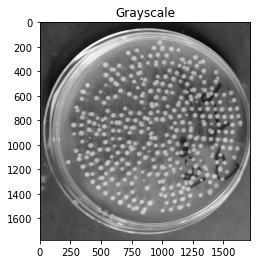

*************Applying OTSU Image*************


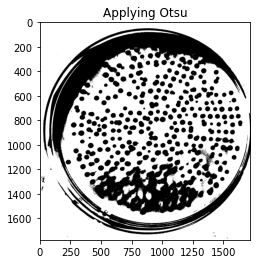

*************Histogram of Image*************


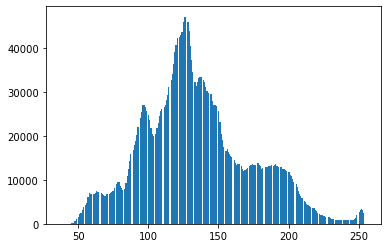

*************Threshold of the Image*************


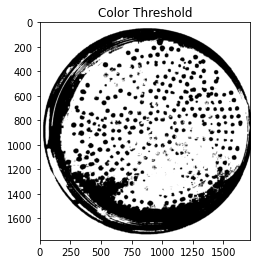

*************Color Threshold Mask of the Image*************


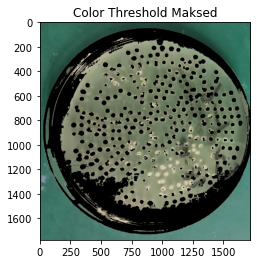

*************K-Mean HSV channel of the Image*************


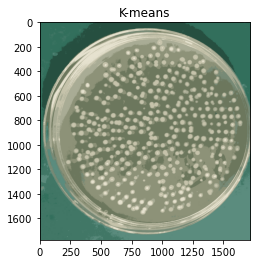

*************K-Mean Labels of the Image*************


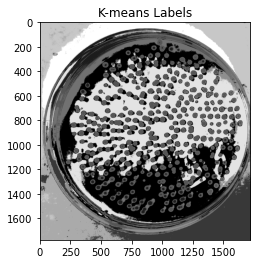

0 [ 35  44 146]
1 [ 25  25 230]
2 [ 82  89 140]
3 [ 27  34 198]
4 [ 34  33 172]
5 [ 58  36 138]
6 [ 81 115 119]
7 [ 81 140 111]
8 [ 42  55 119]
9 [ 79 131  79]
Nuclei label=2, cell label=2
*************Binary Image*************


In [19]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.morphology import extrema
from skimage.morphology import watershed as skwater

def ShowImage(title,img,ctype):
  if ctype=='bgr':
    b,g,r = cv2.split(img)       # get b,g,r
    rgb_img = cv2.merge([r,g,b])     # switch it to rgb
    plt.imshow(rgb_img)
  elif ctype=='hsv':
    rgb = cv2.cvtColor(img,cv2.COLOR_HSV2RGB)
    plt.imshow(rgb)
  elif ctype=='gray':
    plt.imshow(img,cmap='gray')
  elif ctype=='rgb':
    plt.imshow(img)
  else:
    raise Exception("Unknown colour type")
  plt.title(title)
  plt.show()
#Read in image

img         = cv2.imread('bactaria.jpg')
#Convert to a single, grayscale channel
gray        = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#Threshold the image to binary using Otsu's method
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
print("*************Orginal Image*************")
ShowImage('Grayscale',gray,'gray')
print("*************Applying OTSU Image*************")

ShowImage('Applying Otsu',thresh,'gray')
#Make a histogram of the intensities in the grayscale image
print("*************Histogram of Image*************")

plt.hist(gray.ravel(),256)
plt.show()
cell_hsvmin  = (0, 40, 50)  #Lower end of the HSV range defining the nuclei
cell_hsvmax  = (179, 255, 255) #Upper end of the HSV range defining the nuclei
# (hMin = 0 , sMin = 0, vMin = 0), (hMax = 179 , sMax = 255, vMax = 255)
#Transform image to HSV color space
hsv          = cv2.cvtColor(img,cv2.COLOR_BGR2HSV) 
#Threshold based on HSV values
color_thresh = cv2.inRange(hsv, cell_hsvmin, cell_hsvmax) 
print("*************Threshold of the Image*************")

ShowImage('Color Threshold',color_thresh,'gray')

masked = cv2.bitwise_and(img,img, mask=color_thresh)
print("*************Color Threshold Mask of the Image*************")

ShowImage('Color Threshold Maksed',masked,'bgr')
#Convert pixel space to an array of triplets. These are vectors in 3-space.
Z = hsv.reshape((-1,3)) 
#Convert to floating point
Z = np.float32(Z)
#Define the K-means criteria, these are not too important
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
#Define the number of clusters to find
K = 10
#Perform the k-means transformation. What we get back are:
#*Centers: The coordinates at the center of each 3-space cluster
#*Labels: Numeric labels for each cluster
#*Ret: A return code indicating whether the algorithm converged, &c.
ret,label,center = cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

#Produce an image using only the center colours of the clusters
center = np.uint8(center)
khsv   = center[label.flatten()]
khsv   = khsv.reshape((img.shape))

print("*************K-Mean HSV channel of the Image*************")

ShowImage('K-means',khsv,'hsv')

#Reshape labels for masking
label = label.reshape(img.shape[0:2])
print("*************K-Mean Labels of the Image*************")

ShowImage('K-means Labels',label,'gray')
#(Distance,Label) pairs
nucleus_colour = np.array([139, 106, 192])
cell_colour    = np.array([130, 41,  207])
nuclei_label  = (np.inf,-1)
cell_label    = (np.inf,-1)
for l,c in enumerate(center):
  print(l,c)
  dist_nuc = np.sum(np.square(c-nucleus_colour)) #Euclidean distance between colours
  if dist_nuc<nuclei_label[0]:
        nuclei_label=(dist_nuc,l)
  dist_cell = np.sum(np.square(c-cell_colour)) #Euclidean distance between colours
  if dist_cell<cell_label[0]:
        cell_label=(dist_cell,l)
nuclei_label = nuclei_label[1]
cell_label   = cell_label[1]
print("Nuclei label={0}, cell label={1}".format(nuclei_label,cell_label))
#Multiply by 1 to keep image in an integer format suitable for OpenCV
thresh = cv2.bitwise_or(1*(label==nuclei_label),1*(label==cell_label))
thresh = np.uint8(thresh)
print("*************Binary Image*************")

# ShowImage('Binary',thresh,'gray')

# contours, hierarchy = cv2.findContours(khsv, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# contoursImg = cv2.cvtColor(morphImg, cv2.COLOR_GRAY2RGB)
# cv2.drawContours(contoursImg, contours, -1, (255,100,10), 3)
# cv2.imwrite("result.jpg", contoursImg)

# print("Total Number of Bactaria is: ", len(center))
#Remove noise by eliminating single-pixel patches
# kernel  = np.ones((3,3),np.uint8)
# opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN, kernel, iterations = 6)
# ShowImage('Opening',opening,'gray')

The number of objects in this image:  1726


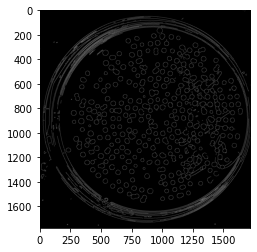

In [20]:
import cv2
import matplotlib.pyplot as plt

image= cv2.imread('bactaria.jpg')

gray= cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (7, 7), 0)
canny = cv2.Canny(blur, 30, 50, 3)
# blurred = cv2.GaussianBlur(gray, (5, 5), 0)
# edges= cv2.Canny(blurred, 50,50)

contours, hierarchy= cv2.findContours(canny.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

number_of_objects_in_image= len(contours)

print ("The number of objects in this image: ", str(number_of_objects_in_image))

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# cv2.imshow('close', gray)
# cv2.imshow('Mask', canny)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
plt.imshow(canny, cmap='gray')

# plt.imshow(edges, cmap='gray')

In [11]:
# Import libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
 
image = cv2.imread('bactaria.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
 
blur = cv2.GaussianBlur(gray, (11, 11), 0)
canny = cv2.Canny(blur, 30, 150, 3)
dilated = cv2.dilate(canny, (1, 1), iterations=0)
 
(cnt, hierarchy) = cv2.findContours(
    dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cv2.drawContours(rgb, cnt, -1, (0, 255, 0), 2)
 
 
print("coins in the image : ", len(cnt))

coins in the image :  52


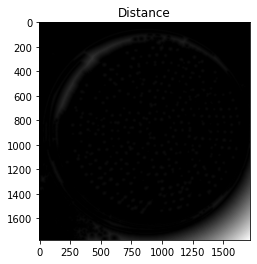

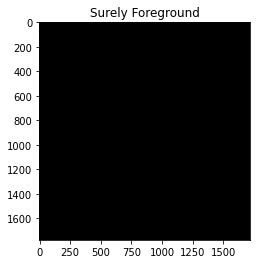

In [35]:
#Identify areas which are surely foreground
fraction_foreground = 5.05
dist         = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist,fraction_foreground*dist.max(),255,0)
ShowImage('Distance',dist,'gray')
ShowImage('Surely Foreground',sure_fg,'gray')

Peaks found: 2


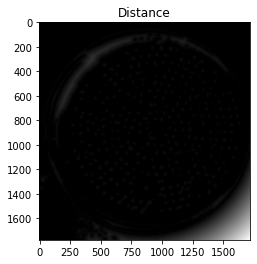

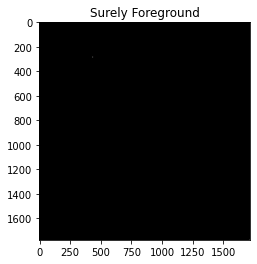

In [14]:
#Identify areas which are surely foreground
h_fraction = 0.1
dist     = cv2.distanceTransform(opening,cv2.DIST_L2,5)
maxima   = extrema.h_maxima(dist, h_fraction*dist.max())
print("Peaks found: {0}".format(np.sum(maxima)))
#Dilate the maxima so we can see them
maxima   = cv2.dilate(maxima, kernel, iterations=2)
ShowImage('Distance',dist,'gray')
ShowImage('Surely Foreground',maxima,'gray')

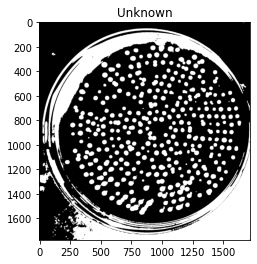

In [15]:
# Finding unknown region
unknown = cv2.subtract(opening,maxima)
ShowImage('Unknown',unknown,'gray')

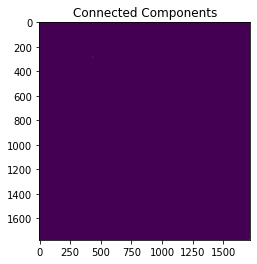

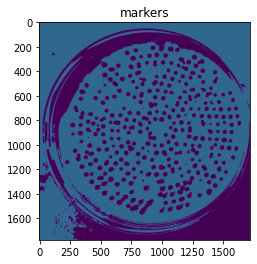

/home/ali/anaconda3/envs/chest-detect/lib/python3.6/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


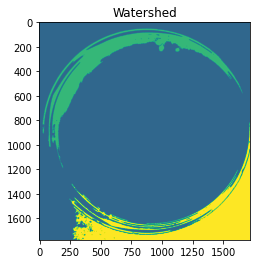

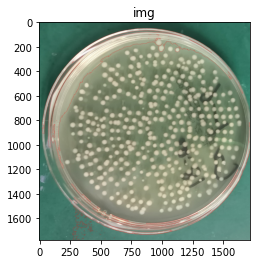

In [16]:
# Marker labelling
ret, markers = cv2.connectedComponents(maxima)
ShowImage('Connected Components',markers,'rgb')

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==np.max(unknown)] = 0

ShowImage('markers',markers,'rgb')

dist    = cv2.distanceTransform(opening,cv2.DIST_L2,5)
markers = skwater(-dist,markers,watershed_line=True)

ShowImage('Watershed',markers,'rgb')
imgout = img.copy()
imgout[markers == 0] = [0,0,255] #Label the watershed_line

ShowImage('img',imgout,'bgr')

In [25]:
import cv2
import numpy as np

def nothing(x):
    pass

# Load image
image = cv2.imread('/home/ali/Desktop/python_chilla/Python_Chilla/projects/bacterial_count/bactaria.jpg')

# Create a window
cv2.namedWindow('image')

# Create trackbars for color change
# Hue is from 0-179 for Opencv
cv2.createTrackbar('HMin', 'image', 0, 179, nothing)
cv2.createTrackbar('SMin', 'image', 0, 255, nothing)
cv2.createTrackbar('VMin', 'image', 0, 255, nothing)
cv2.createTrackbar('HMax', 'image', 0, 179, nothing)
cv2.createTrackbar('SMax', 'image', 0, 255, nothing)
cv2.createTrackbar('VMax', 'image', 0, 255, nothing)

# Set default value for Max HSV trackbars
cv2.setTrackbarPos('HMax', 'image', 179)
cv2.setTrackbarPos('SMax', 'image', 255)
cv2.setTrackbarPos('VMax', 'image', 255)

# Initialize HSV min/max values
hMin = sMin = vMin = hMax = sMax = vMax = 0
phMin = psMin = pvMin = phMax = psMax = pvMax = 0

while(1):
    # Get current positions of all trackbars
    hMin = cv2.getTrackbarPos('HMin', 'image')
    sMin = cv2.getTrackbarPos('SMin', 'image')
    vMin = cv2.getTrackbarPos('VMin', 'image')
    hMax = cv2.getTrackbarPos('HMax', 'image')
    sMax = cv2.getTrackbarPos('SMax', 'image')
    vMax = cv2.getTrackbarPos('VMax', 'image')

    # Set minimum and maximum HSV values to display
    lower = np.array([hMin, sMin, vMin])
    upper = np.array([hMax, sMax, vMax])

    # Convert to HSV format and color threshold
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, lower, upper)
    result = cv2.bitwise_and(image, image, mask=mask)

    # Print if there is a change in HSV value
    if((phMin != hMin) | (psMin != sMin) | (pvMin != vMin) | (phMax != hMax) | (psMax != sMax) | (pvMax != vMax) ):
        print("(hMin = %d , sMin = %d, vMin = %d), (hMax = %d , sMax = %d, vMax = %d)" % (hMin , sMin , vMin, hMax, sMax , vMax))
        phMin = hMin
        psMin = sMin
        pvMin = vMin
        phMax = hMax
        psMax = sMax
        pvMax = vMax

    # Display result image
    cv2.imshow('image', result)
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()

(hMin = 0 , sMin = 0, vMin = 0), (hMax = 179 , sMax = 255, vMax = 255)
